# Forecasting with System of Equation

## Data Import 

In [ ]:
import pandas as pd 

df_ts = pd.read_excel("MSTR-Bitcoin (2018-2025).xlsx", index_col=0)

### convert to log return

import numpy as np 
LR_ts = np.log(df_ts / df_ts.shift(1))

### Dropping the NAs
LR_ts = LR_ts.dropna()

## Vector Autoregression

In [ ]:
var_df = LR_ts.iloc[:,0:2]

In [ ]:
var_df

,MSTR,Bitcoin
Date,,
2018-01-03,0.002201,0.016522
2018-01-04,0.010031,-0.005179
2018-01-08,0.011268,-0.000743
2018-01-09,0.014146,-0.029085
2018-01-10,-0.015408,-0.000350
...,...,...
2025-03-25,0.053398,0.000207
2025-03-26,0.009015,-0.006834
2025-03-27,-0.042402,-0.000021


### LAG Selection

In [ ]:
#### Import library for VAR model 
from statsmodels.tsa.api import VAR

def lag_select(dz):
    # Fit a VAR model
    model = VAR(dz)
    lag_selection = model.select_order(maxlags=4)
    return lag_selection.summary()

In [ ]:
lag_select(var_df)

c:\Users\mayow\Desktop\Spillover MSTR-Bitcoin\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-12.31,-12.30,4.502e-06,-12.31
1,-12.40*,-12.38*,4.116e-06*,-12.39*
2,-12.40,-12.37,4.126e-06,-12.39
3,-12.40,-12.35,4.131e-06,-12.38
4,-12.40,-12.34,4.133e-06,-12.38


In case of more lags, the number of data points required to fit VAR model would be more. 

In our case we will settle down to choosing "1" Lag



### Fitting VAR

In [ ]:
def VAR_fit(dz,lag_order):
    # Fit a VAR model
    model = VAR(dz)
    fitted_model = model.fit(lag_order)
    return fitted_model

In [ ]:
#### Calling the VAR function 
var_model_fit = VAR_fit(var_df,1)

c:\Users\mayow\Desktop\Spillover MSTR-Bitcoin\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
var_model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 24, Jun, 2025
Time:                     00:05:36
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -12.3854
Nobs:                     1818.00    HQIC:                  -12.3968
Log likelihood:           6121.56    FPE:                4.10403e-06
AIC:                     -12.4035    Det(Omega_mle):     4.09052e-06
--------------------------------------------------------------------
Results for equation MSTR
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.001505         0.001185            1.270           0.204
L1.MSTR           -0.095241         0.023498           -4.053           0.000
L1.Bitcoin         0.362050         0.029409           12.311           0

Try to interpret the results

## Features of VAR

### Granger Causality

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

# Granger Causality Tests
def granger_causality_tests(data, variables, max_lag):
    results = {}
    for var1 in variables:
        for var2 in variables:
            if var1 != var2:
                test_result = grangercausalitytests(data[[var1, var2]], max_lag, verbose=False)
                p_values = [round(test[0]['ssr_ftest'][1], 4) for test in test_result.values()]
                results[f"{var2} causes {var1}"] = p_values
    return pd.DataFrame(results, index=[f"Lag {i+1}" for i in range(max_lag)])

print("\nGranger Causality Tests:")
causality_results = granger_causality_tests(var_df, var_df.columns, 1)
print(causality_results)



Granger Causality Tests:
       MSTR causes Bitcoin  Bitcoin causes MSTR
Lag 1                  0.0               0.2079


c:\Users\mayow\Desktop\Spillover MSTR-Bitcoin\venv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\mayow\Desktop\Spillover MSTR-Bitcoin\venv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Reject Null Hypothesis for MSTR causes Bitcoin but
Fail to reject Null Hypothesis for Bitcoin causes MSTR.

### Impulse Response

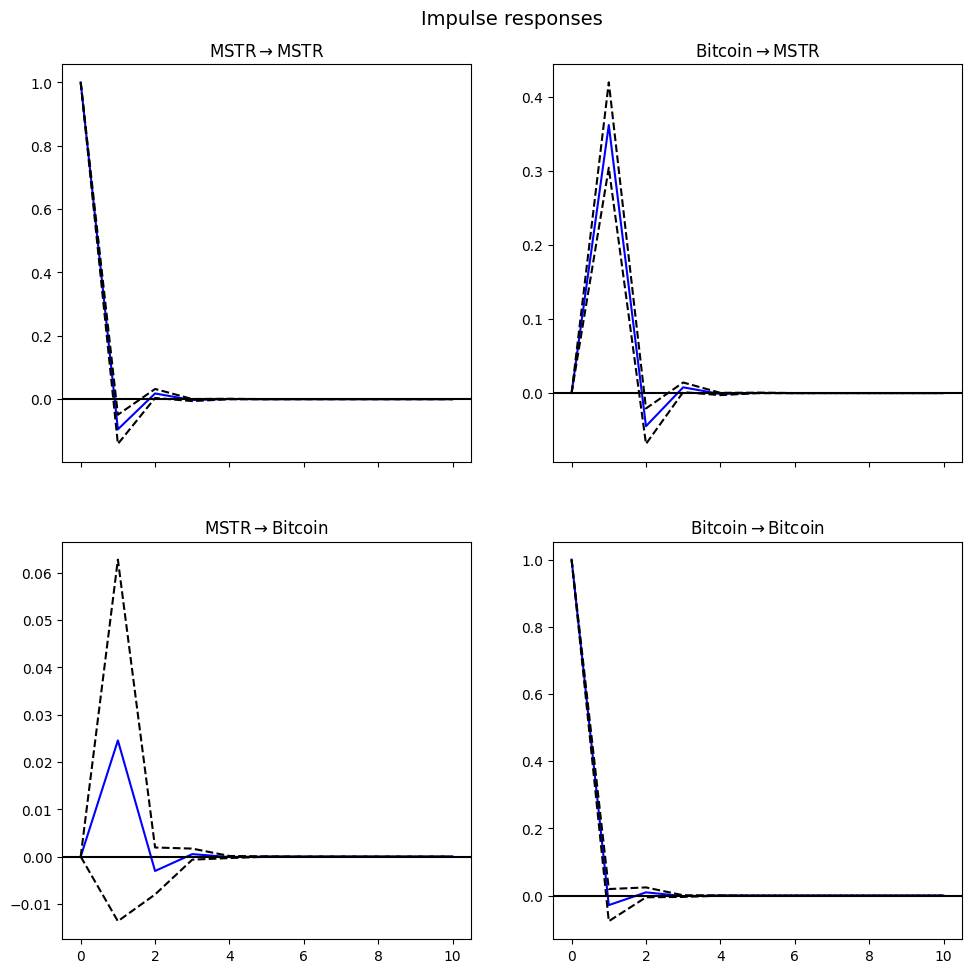

In [ ]:
# Impulse Response Function
import matplotlib.pyplot as plt

irf = var_model_fit.irf(10)  # IRF for 10 periods
irf.plot(orth=False)
plt.show()

### Rolling Spillover Estimation (100-day window)

In [ ]:
def rolling_spillover(data, lag_order=1, forecast_steps=10, window=100):
    spillover_list = []
    rolling_dates = []

    for start in range(len(data) - window + 1):
        end = start + window
        sample = data.iloc[start:end]
        model = VAR(sample)
        results = model.fit(lag_order)

        sigma_u = np.asarray(results.sigma_u)
        sd_u = np.sqrt(np.diag(sigma_u))
        fevd = results.fevd(forecast_steps, sigma_u / sd_u)

        fe = fevd.decomp[:, -1, :]
        fevd_normalized = (fe / fe.sum(1)[:, None] * 100)
        spillover_list.append(fevd_normalized)
        rolling_dates.append(sample.index[-1])

    return np.array(spillover_list), rolling_dates

In [ ]:
### Run the rolling spillover over the post-adoption period
rolling_results, rolling_dates = rolling_spillover(var_df, lag_order=1, forecast_steps=10, window=100)

### Convert the last column's cross-effects into DataFrame for plotting or export
# Example: BTC variance explained by MSTR and vice versa
spillover_btc = [m[0, 1] for m in rolling_results]  # How much of BTC is explained by MSTR
spillover_mstr = [m[1, 0] for m in rolling_results]  # How much of MSTR is explained by BTC
total_spill = np.array(spillover_btc) + np.array(spillover_mstr)
net_spill = np.array(spillover_mstr) - np.array(spillover_btc)  # Net: BTC to MSTR minus reverse


rolling_df = pd.DataFrame({
    'Date': rolling_dates,
    'BTC_from_MSTR': spillover_btc,
    'MSTR_from_BTC': spillover_mstr,
    'Total_Spillover': total_spill,
    'Net_Spillover': net_spill
})

rolling_df.set_index('Date', inplace=True)
rolling_df.to_excel('rolling_spillover.xlsx', engine='openpyxl')

c:\Users\mayow\Desktop\Spillover MSTR-Bitcoin\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mayow\Desktop\Spillover MSTR-Bitcoin\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mayow\Desktop\Spillover MSTR-Bitcoin\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mayow\Desktop\Spillover MSTR-Bitcoin\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it ha

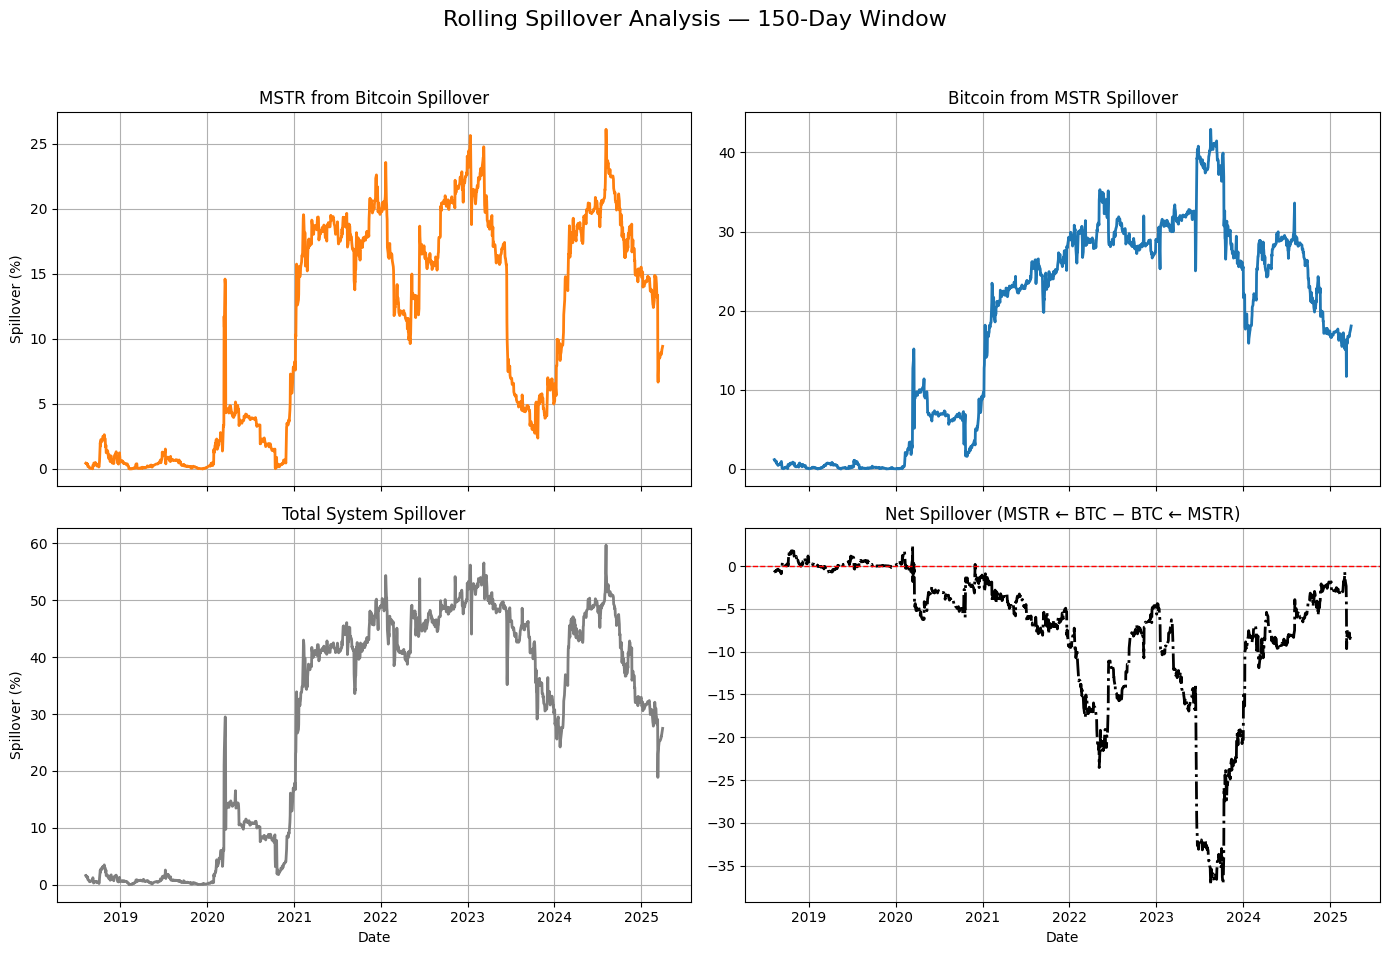

In [ ]:

# --- Ensure rolling_df is already populated as per previous code ---

fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
fig.suptitle("Rolling Spillover Analysis — 100-Day Window", fontsize=16)

# --- Subplot 1: MSTR from BTC ---
axs[0, 0].plot(rolling_df.index, rolling_df['MSTR_from_BTC'], color='tab:orange', linewidth=2)
axs[0, 0].set_title('MSTR from Bitcoin Spillover')
axs[0, 0].set_ylabel('Spillover (%)')
axs[0, 0].grid(True)

# --- Subplot 2: BTC from MSTR ---
axs[0, 1].plot(rolling_df.index, rolling_df['BTC_from_MSTR'], color='tab:blue', linewidth=2)
axs[0, 1].set_title('Bitcoin from MSTR Spillover')
axs[0, 1].grid(True)

# --- Subplot 3: Total Spillover ---
axs[1, 0].plot(rolling_df.index, rolling_df['Total_Spillover'], color='tab:gray', linewidth=2)
axs[1, 0].set_title('Total System Spillover')
axs[1, 0].set_ylabel('Spillover (%)')
axs[1, 0].set_xlabel('Date')
axs[1, 0].grid(True)

# --- Subplot 4: Net Spillover ---
axs[1, 1].plot(rolling_df.index, rolling_df['Net_Spillover'], color='black', linestyle='-.', linewidth=2)
axs[1, 1].axhline(0, color='red', linestyle='--', linewidth=1)
axs[1, 1].set_title('Net Spillover (MSTR ← BTC − BTC ← MSTR)')
axs[1, 1].set_xlabel('Date')
axs[1, 1].grid(True)

# --- Final layout and export ---
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()